In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#  Assignment: Handwritten digits dataset

The dataset that you will use in this assignment is the [*digits* dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) which contains $1797$ images of $10$ hand-written digits. The digits have been preprocessed so that $32 \times 32$ bitmaps are divided into non-overlapping blocks of $4 \times 4$ and the number of on pixels are counted in each block. This generates an input matrix of $8 \times 8$ where each element is an integer in the range of $[0, ..., 16]$. This reduces dimensionality and gives invariance to small distortions.

For further information on NIST preprocessing routines applied to this data, see M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, *NIST Form-Based Handprint Recognition System*, NISTIR 5469, 1994.

As before, use the `sklearn`'s data uploading routines to load the dataset and get the data fields:

In [2]:
from sklearn import datasets
digits = datasets.load_digits()
list(digits.keys())

['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']

In [3]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [4]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [5]:
y.shape

(1797,)

You can access the digits and visualise them using the following code (feel free to select another digit):

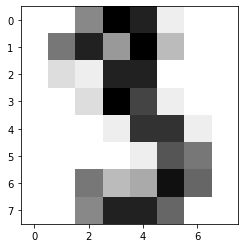

In [6]:
some_digit = X[3]
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
#plt.axis("off")
plt.show()

In [7]:
y[3]

3

For the rest of the practical, apply the data preprocessing techniques, implement and evaluate the classification models on the digits dataset using the steps that you applied above to the iris dataset.

============================================================================================

In [8]:
f'Unique Target Values: {np.unique(y)}'

'Unique Target Values: [0 1 2 3 4 5 6 7 8 9]'

In [9]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

============================================================================================

- This is a multiclass claffification problem. We have 10 classes corresponding to the integer digits from 0 to 9. Plots of one feature versus the other are not informative in this case.<br><br>
- The most informative visualisation is the imgshow above: the darker the $4\times4$ square, the more pixels are within the square. This produces an out of focus image, since we reduce $32^2$ 1X1 binary (black and white) pixels to $8^2$ $4\times4$ (shades of gray with darker corresponding to more $1\times1$ pixels contained in the $4\times4$ pixel bin) pixels.<br><br>
- Another visualisation that might be informative is a barplot showing the average total number of pixels for each digit class. This might be useful for example in tracking the performance of an algorithm that weights probability of different classes in the classification problem, based on the aggregate number of pixels of each class.

In [10]:
df_digits = pd.DataFrame(data=np.sum(X,axis=1), index=pd.Index(data=y, name='digit'),
                         columns=['tot_pixels'])


In [11]:
means=df_digits.groupby('digit').mean()


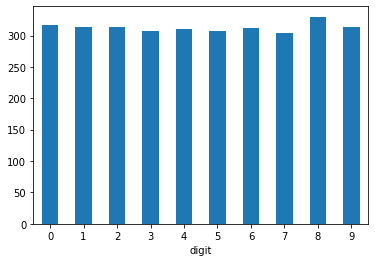

In [12]:
means.plot(kind='bar', legend=False, rot=0)
plt.show()

Each digit has on average pretty much the same number of pixels, so we don't need to concern ourselves with the possibility of a significant variation in weights allocated to different digits based on the total number of pixels. An algorithm solely based on this feature would not be very accurate anyway.

============================================================================================

## Split the data into train and test set

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y))
X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]
print(f'Training --> {X_train.shape[0]}', f'Test --> {X_test.shape[0]}')

Training --> 1437 Test --> 360


# Binary Selection

Here we analyse the binary subproblem '7 --> 1 \ not 7 --> 0'. The interest in this particular binary subproblem lies in the fact that a handwritten 7 often looks like a handwritten 1. We subsequently report metrics measuring performance of four algorithms selected below.

#### Select the models we will work with:

- Perceptron (`SGD Classifier` implementing a SVM)
- `Logistic Regression`
- Perceptron with `RBF Sampler`
- Gaussian `Naive Bayes`

In [14]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve, roc_curve,
                             roc_auc_score, confusion_matrix)

# calling the constructors
sgd = SGDClassifier(max_iter=5, tol=None, loss='perceptron', learning_rate='constant',
                   eta0=1, penalty=None, random_state=42)
sgd_rbf = SGDClassifier(max_iter=100, tol=None, loss='perceptron', learning_rate='constant',
                   eta0=1, penalty=None, random_state=42)
log_reg = LogisticRegression(solver='sag', max_iter=1000)
gnb = GaussianNB()
transformer = RBFSampler(gamma=1, random_state=42, n_components=1000)
X_train_rbf = transformer.fit_transform(X_train)

print("Apply RBF sampler to data: ", X_train.shape, '-->', X_train_rbf.shape)




Apply RBF sampler to data:  (1437, 64) --> (1437, 1000)


***Note***: We increased the max number of iterations to 1000 for logistic regression to reach its stopping criterion<br>(default tol=1e-3) before reaching the max_iter limit.

*TODO: Explore setting dimensions of RBF sampler to greater values.*

In [15]:
y_7 = (y_train == 7)

In [16]:
# fitting to data
sgd.fit(X_train, y_7)
sgd_rbf.fit(X_train_rbf, y_7)
log_reg.fit(X_train, y_7)
gnb.fit(X_train, y_7)

GaussianNB()

## Evaluation

In [17]:
# Accuracy scores for 5 cross validation runs
log_reg_scores = cross_val_score(log_reg, X_train, y_7, scoring='accuracy', cv=5)
sgd_scores = cross_val_score(sgd, X_train, y_7, scoring='accuracy', cv=5)
sgd_rbf_scores = cross_val_score(sgd_rbf, X_train, y_7, scoring='accuracy', cv=5)
gnb_scores = cross_val_score(gnb, X_train, y_7, scoring='accuracy', cv=5)

print('Logistic Regression:\n', log_reg_scores, '\nAverage: ',np.mean(log_reg_scores))
print()
print('Perceptron:\n', sgd_scores, '\nAverage: ', np.mean(sgd_scores))
print()
print('Perceptron with RBF:\n', sgd_rbf_scores, '\nAverage: ', np.mean(sgd_rbf_scores))
print()
print('Gaussian Naive Bayes:\n', gnb_scores, '\nAverage: ', np.mean(gnb_scores))

Logistic Regression:
 [0.99305556 0.98611111 1.         0.99303136 0.99303136] 
Average:  0.9930458768873404

Perceptron:
 [0.97916667 0.95486111 0.99651568 1.         0.98954704] 
Average:  0.9840180991095625

Perceptron with RBF:
 [0.99305556 0.98958333 1.         0.99303136 0.9825784 ] 
Average:  0.9916497289972901

Gaussian Naive Bayes:
 [0.81944444 0.875      0.80836237 0.82229965 0.85365854] 
Average:  0.8357530003871467


In [18]:
log_pred = cross_val_predict(log_reg, X_train, y_7, cv=5, method='predict') # default is predict
sgd_pred = cross_val_predict(sgd, X_train, y_7, cv=5)
sgd_rbf_pred = cross_val_predict(sgd_rbf, X_train_rbf, y_7, cv=5)
gnb_pred = cross_val_predict(gnb, X_train, y_7, cv=5)


In [19]:
# Logistic Regression
print(f'Recall --> {recall_score(y_7, log_pred)}',
     f'Precision --> {precision_score(y_7, log_pred)}',
     f'F1 score --> {f1_score(y_7, log_pred)}', sep='\n')

Recall --> 0.965034965034965
Precision --> 0.965034965034965
F1 score --> 0.965034965034965


In [20]:
# Perceptron
print(f'Recall --> {recall_score(y_7, sgd_pred)}',
     f'Precision --> {precision_score(y_7, sgd_pred)}',
     f'F1 score --> {f1_score(y_7, sgd_pred)}', sep='\n')

Recall --> 0.9440559440559441
Precision --> 0.9
F1 score --> 0.9215017064846417


In [21]:
# Perceptron with kernel trick
print(f'Recall --> {recall_score(y_7, sgd_rbf_pred)}',
     f'Precision --> {precision_score(y_7, sgd_rbf_pred)}',
     f'F1 score --> {f1_score(y_7, sgd_rbf_pred)}', sep='\n')

Recall --> 0.06993006993006994
Precision --> 0.07246376811594203
F1 score --> 0.07117437722419928


In [22]:
# Naive Bayes
print(f'Recall --> {recall_score(y_7, gnb_pred)}',
     f'Precision --> {precision_score(y_7, gnb_pred)}',
     f'F1 score --> {f1_score(y_7, gnb_pred)}', sep='\n')

Recall --> 0.986013986013986
Precision --> 0.376
F1 score --> 0.5444015444015443


#### Confusion matrix for each model

In [23]:
# logistic regression
conf = confusion_matrix(y_7, log_pred)
df = pd.DataFrame(data=conf, index=['y=0', 'y=1'],
                  columns=[r'$\bf\hat{y}$'+ r'=0', r'$\bf\hat{y}$'+ '=1'])
df

,$\bf\hat{y}$=0,$\bf\hat{y}$=1
y=0,1289,5
y=1,5,138


In [24]:
# Perceptron
conf = confusion_matrix(y_7, sgd_pred)
df = pd.DataFrame(data=conf, index=['y=0', 'y=1'],
                  columns=[r'$\bf\hat{y}$'+ r'=0', r'$\bf\hat{y}$'+ '=1'])
df

,$\bf\hat{y}$=0,$\bf\hat{y}$=1
y=0,1279,15
y=1,8,135


In [25]:
# Perceptron with RBF
conf = confusion_matrix(y_7, sgd_rbf_pred)
df = pd.DataFrame(data=conf, index=['y=0', 'y=1'],
                  columns=[r'$\bf\hat{y}$'+ r'=0', r'$\bf\hat{y}$'+ '=1'])
df

,$\bf\hat{y}$=0,$\bf\hat{y}$=1
y=0,1166,128
y=1,133,10


In [26]:
# Naive Bayes
conf = confusion_matrix(y_7, gnb_pred)
df = pd.DataFrame(data=conf, index=['y=0', 'y=1'],
                  columns=[r'$\bf\hat{y}$'+ r'=0', r'$\bf\hat{y}$'+ '=1'])
df

,$\bf\hat{y}$=0,$\bf\hat{y}$=1
y=0,1060,234
y=1,2,141


Plotting precision-recall curves

In [27]:
log_scores = cross_val_predict(log_reg, X_train, y_7, method='decision_function', cv=5)
sgd_scores = cross_val_predict(sgd, X_train, y_7, method='decision_function', cv=5)
sgd_rbf_scores = cross_val_predict(sgd_rbf, X_train_rbf, y_7, method='decision_function',
                                   cv=5)
gnb_scores = cross_val_predict(gnb, X_train, y_7, method='predict_proba', cv=5)

In [28]:
gnb_scores.shape

(1437, 2)

In [29]:
print(f'Class column 1: {gnb.classes_[0]}', f'Class column 2: {gnb.classes_[1]}', sep='\n')

Class column 1: False
Class column 2: True


In [30]:
gnb_scores = gnb_scores[:,1]

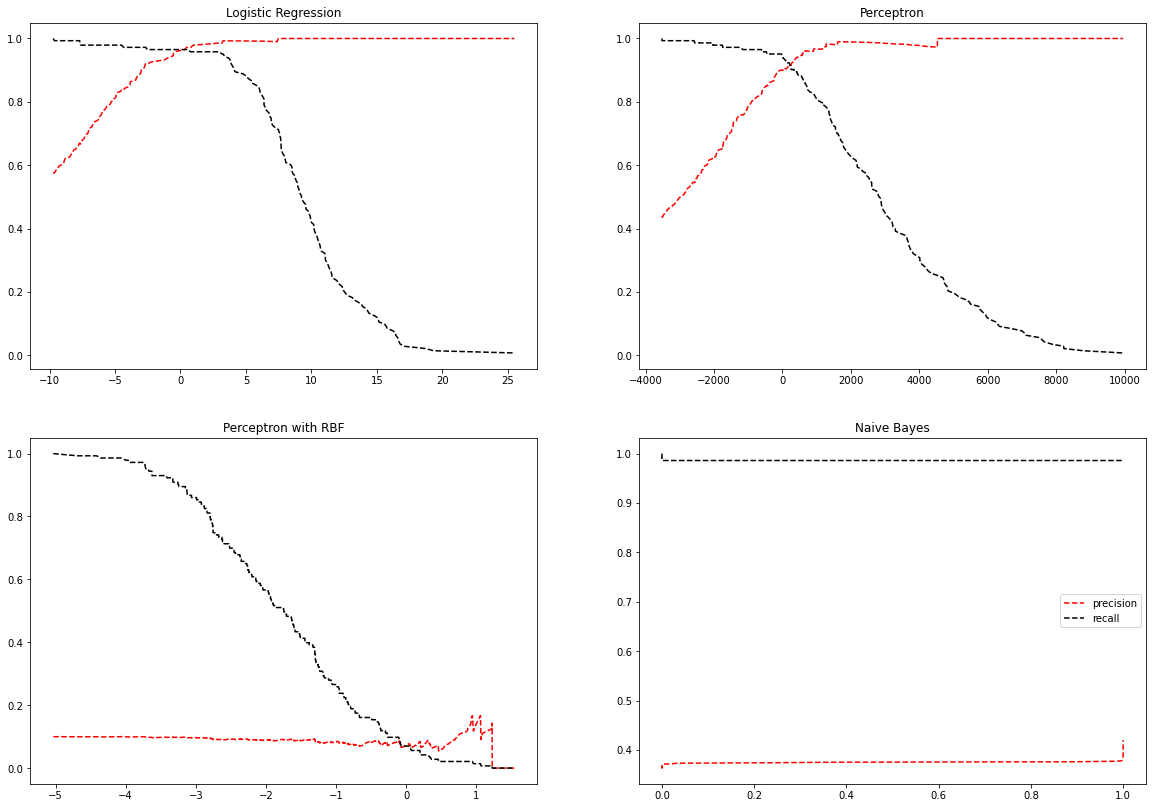

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
# Logistic Regression
precision, recall, thresholds = precision_recall_curve(y_7, log_scores)
ax[0][0].plot(thresholds, precision[:-1],'r--', label='precision')
ax[0][0].plot(thresholds, recall[:-1],'k--', label='recall')
ax[0][0].set_title('Logistic Regression')

# Perceptron 
precision, recall, thresholds = precision_recall_curve(y_7, sgd_scores)
ax[0][1].plot(thresholds, precision[:-1],'r--', label='precision')
ax[0][1].plot(thresholds, recall[:-1],'k--', label='recall')
ax[0][1].set_title('Perceptron')

# Perceptron with RBF sampler
precision, recall, thresholds = precision_recall_curve(y_7, sgd_rbf_scores)
ax[1][0].plot(thresholds, precision[:-1],'r--', label='precision')
ax[1][0].plot(thresholds, recall[:-1],'k--', label='recall')
ax[1][0].set_title('Perceptron with RBF')

# Naive Bayes
precision, recall, thresholds = precision_recall_curve(y_7, gnb_scores)
ax[1][1].plot(thresholds, precision[:-1],'r--', label='precision')
ax[1][1].plot(thresholds, recall[:-1],'k--', label='recall')
ax[1][1].set_title('Naive Bayes')

plt.legend()
plt.show()

In [32]:
gnb_scores.shape

(1437,)

**The Logistic regression model again proves to be by far the superior model for the binary classification subproblem.**

#### ROC curve

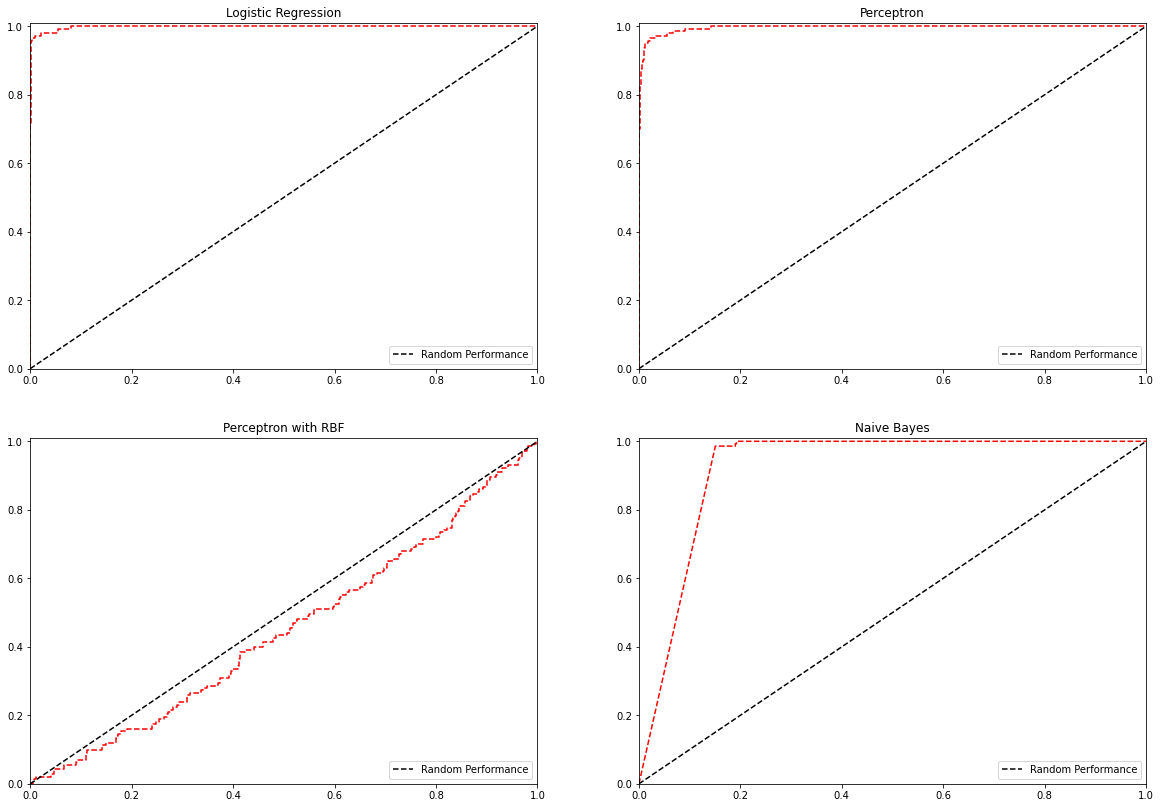

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 14))

# Logistic Regression
fpr, tpr, thresholds = roc_curve(y_7,log_scores)
axs[0][0].plot(fpr, tpr, 'r--')
axs[0][0].plot([0, 1], [0,1], 'k--', label='Random Performance')
axs[0][0].set_xlim([0,1])
axs[0][0].set_ylim([0,1.01])
axs[0][0].set_title('Logistic Regression')
axs[0][0].legend(loc='lower right')

# Perceptron
fpr, tpr, thresholds = roc_curve(y_7,sgd_scores)
axs[0][1].plot(fpr, tpr, 'r--')
axs[0][1].plot([0, 1], [0,1], 'k--', label='Random Performance')
axs[0][1].set_xlim([0,1])
axs[0][1].set_ylim([0,1.01])
axs[0][1].set_title('Perceptron')
axs[0][1].legend(loc='lower right')

# Perceptron with RBF
fpr, tpr, thresholds = roc_curve(y_7,sgd_rbf_scores)
axs[1][0].plot(fpr, tpr, 'r--')
axs[1][0].plot([0, 1], [0,1], 'k--', label='Random Performance')
axs[1][0].set_xlim([0,1])
axs[1][0].set_ylim([0,1.01])
axs[1][0].set_title('Perceptron with RBF')
axs[1][0].legend(loc='lower right')

# Naive Bayes
fpr, tpr, thresholds = roc_curve(y_7,gnb_scores)
axs[1][1].plot(fpr, tpr, 'r--')
axs[1][1].plot([0, 1], [0,1], 'k--', label='Random Performance')
axs[1][1].set_xlim([0,1])
axs[1][1].set_ylim([0,1.01])
axs[1][1].set_title('Naive Bayes')
axs[1][1].legend(loc='lower right')

plt.show()

In [34]:
# roc score
print(f'Logistic Regression: {roc_auc_score(y_7, log_scores)}')
print(f'Perceptron: {roc_auc_score(y_7, sgd_scores)}')
print(f'Perceptron with RBF: {roc_auc_score(y_7, sgd_rbf_scores)}')
print(f'Naive Bayes: {roc_auc_score(y_7, gnb_scores)}')

Logistic Regression: 0.9982490461624929
Perceptron: 0.9955091276575049
Perceptron with RBF: 0.45042747052020626
Naive Bayes: 0.923030987559581


# Multiclass classification

*TODO: use one vs one strategy*

In [35]:
sgd.fit(X_train, y_train)
sgd_rbf.fit(X_train_rbf, y_train)
log_reg.fit(X_train, y_train)
gnb.fit(X_train, y_train)

GaussianNB()

In [36]:
# Accuracy scores for 5 cross validation runs
log_reg_scores = cross_val_score(log_reg, X_train, y_train, scoring='accuracy', cv=5)
sgd_scores = cross_val_score(sgd, X_train, y_train, scoring='accuracy', cv=5)
sgd_rbf_scores = cross_val_score(sgd_rbf, X_train, y_7, scoring='accuracy', cv=5)
gnb_scores = cross_val_score(gnb, X_train, y_7, scoring='accuracy', cv=5)

print('Logistic Regression:\n', log_reg_scores, '\nAverage: ',np.mean(log_reg_scores))
print()
print('Perceptron:\n', sgd_scores, '\nAverage: ', np.mean(sgd_scores))
print()
print('Perceptron with RBF:\n', sgd_rbf_scores, '\nAverage: ', np.mean(sgd_rbf_scores))
print()
print('Gaussian Naive Bayes:\n', gnb_scores, '\nAverage: ', np.mean(gnb_scores))

Logistic Regression:
 [0.96527778 0.95833333 0.96864111 0.96515679 0.95470383] 
Average:  0.9624225706542779

Perceptron:
 [0.9375     0.86805556 0.92682927 0.94076655 0.89547038] 
Average:  0.9137243515292297

Perceptron with RBF:
 [0.99305556 0.98958333 1.         0.99303136 0.9825784 ] 
Average:  0.9916497289972901

Gaussian Naive Bayes:
 [0.81944444 0.875      0.80836237 0.82229965 0.85365854] 
Average:  0.8357530003871467


In [37]:
log_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method='predict')
sgd_pred = cross_val_predict(sgd, X_train, y_train, cv=5)
sgd_rbf_pred = cross_val_predict(sgd_rbf, X_train_rbf, y_train, cv=5)
gnb_pred = cross_val_predict(gnb, X_train, y_train, cv=5)

In [38]:
# Logistic Regression
print( f"Recall --> {recall_score(y_train, log_pred, average='weighted')}",
f"Precision --> {precision_score(y_train, log_pred, average='weighted')}",
f"F1 score --> {f1_score(y_train, log_pred, average='weighted')}", sep='\n')

Recall --> 0.9638135003479471
Precision --> 0.9638784286466721
F1 score --> 0.9637203024352238


In [39]:
# Perceptron
print(f"Recall --> {recall_score(y_train, sgd_pred, average='weighted')}",
     f"Precision --> {precision_score(y_train, sgd_pred, average='weighted')}",
     f"F1 score --> {f1_score(y_train, sgd_pred, average='weighted')}", sep='\n')

Recall --> 0.9137091162143354
Precision --> 0.9172770149049306
F1 score --> 0.9105836764783534


In [40]:
# Perceptron with kernel trick
print(f"Recall --> {recall_score(y_train, sgd_rbf_pred, average='weighted')}",
     f"Precision --> {precision_score(y_train, sgd_rbf_pred, average='weighted')}",
     f"F1 score --> {f1_score(y_train, sgd_rbf_pred, average='weighted')}", sep='\n')

Recall --> 0.09812108559498957
Precision --> 0.0994783375189047
F1 score --> 0.09598307389304381


In [41]:
# Naive Bayes
print(f"Recall --> {recall_score(y_train, gnb_pred, average='weighted')}",
     f"Precision --> {precision_score(y_train, gnb_pred, average='weighted')}",
     f"F1 score --> {f1_score(y_train, gnb_pred, average='weighted')}", sep='\n')

Recall --> 0.8274182324286709
Precision --> 0.871126229005243
F1 score --> 0.8294072137190873


# Error Analysis

We report confusion matrices for our two best models below.

### Logistic Regression

In [42]:
conf = confusion_matrix(y_train, log_pred)
df = pd.DataFrame(data=conf, index=pd.RangeIndex(start=0,stop=10),
                  columns=np.arange(start=0, stop=10))
df

,0,1,2,3,4,5,6,7,8,9
0,141,0,0,0,0,1,0,0,0,0
1,0,142,0,0,1,0,1,0,1,1
2,0,2,139,1,0,0,0,0,0,0
3,0,0,1,141,0,2,0,0,2,0
4,0,1,0,0,141,0,0,1,1,1
5,0,0,1,0,1,137,1,2,0,3
6,0,1,0,0,0,1,143,0,0,0
7,0,0,0,2,0,0,0,138,0,3
8,0,5,2,0,2,2,2,0,125,1
9,1,0,0,1,0,1,0,1,2,138


**We viualise the error frequency of each worngly assigned pixel region in proportion to all wrongly assigned regions.**

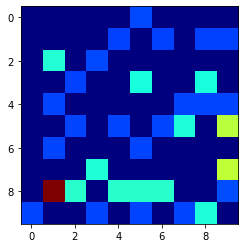

In [43]:
row_sums = conf.sum(axis=1, keepdims=True)
norm_conf_mx = conf / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.imshow(norm_conf_mx, cmap = "jet")
plt.show()

### Perceptron

In [44]:
# Perceptron
conf = confusion_matrix(y_train, sgd_pred)
df = pd.DataFrame(data=conf, index=pd.RangeIndex(start=0,stop=10),
                  columns=np.arange(start=0, stop=10))
df

,0,1,2,3,4,5,6,7,8,9
0,139,0,0,0,0,3,0,0,0,0
1,0,137,1,0,4,0,1,0,1,2
2,0,1,139,2,0,0,0,0,0,0
3,0,0,0,141,0,3,0,0,1,1
4,0,2,0,0,140,0,0,1,1,1
5,1,1,0,0,1,139,1,0,0,2
6,0,3,0,1,2,1,138,0,0,0
7,0,0,1,2,0,1,0,137,0,2
8,0,15,4,18,5,7,6,0,82,2
9,0,5,0,6,1,7,0,0,4,121


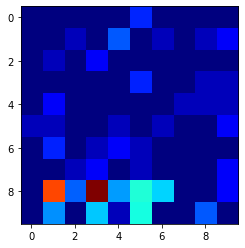

In [45]:
row_sums = conf.sum(axis=1, keepdims=True)
norm_conf_mx = conf / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.imshow(norm_conf_mx, cmap = "jet")
plt.show()

# Testing

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
log_pred = log_reg.predict(X_test)
sgd_pred = sgd.predict(X_test)
X_test_rbf = transformer.fit_transform(X_test)
sgd_rbf_pred = sgd_rbf.predict(X_test_rbf)
gnb_pred = gnb.predict(X_test)

In [49]:
# Logistic Regression
print( f"Accuracy --> {accuracy_score(y_test, log_pred)}",
      f"Recall --> {recall_score(y_test, log_pred, average='weighted')}",
      f"Precision --> {precision_score(y_test, log_pred, average='weighted')}",
      f"F1 score --> {f1_score(y_test, log_pred, average='weighted')}", sep='\n')

Accuracy --> 0.9611111111111111
Recall --> 0.9611111111111111
Precision --> 0.9616884090568301
F1 score --> 0.961140796891353


In [50]:
# Perceptron
print( f"Accuracy --> {accuracy_score(y_test, sgd_pred)}",
      f"Recall --> {recall_score(y_test, sgd_pred, average='weighted')}",
      f"Precision --> {precision_score(y_test, sgd_pred, average='weighted')}",
      f"F1 score --> {f1_score(y_test, sgd_pred, average='weighted')}", sep='\n')

Accuracy --> 0.9472222222222222
Recall --> 0.9472222222222222
Precision --> 0.9506739556477815
F1 score --> 0.9472461128819086


In [51]:
# Perceptron with kernel trick
print( f"Accuracy --> {accuracy_score(y_test, sgd_rbf_pred)}",
      f"Recall --> {recall_score(y_test, sgd_rbf_pred, average='weighted')}",
      f"Precision --> {precision_score(y_test, sgd_rbf_pred, average='weighted')}",
      f"F1 score --> {f1_score(y_test, sgd_rbf_pred, average='weighted')}", sep='\n')

Accuracy --> 0.10555555555555556
Recall --> 0.10555555555555556
Precision --> 0.10646506794510001
F1 score --> 0.10532448282389988


In [52]:
# Naive Bayes
print( f"Accuracy --> {accuracy_score(y_test, gnb_pred)}",
      f"Recall --> {recall_score(y_test, gnb_pred, average='weighted')}",
      f"Precision --> {precision_score(y_test, gnb_pred, average='weighted')}",
      f"F1 score --> {f1_score(y_test, gnb_pred, average='weighted')}", sep='\n')

Accuracy --> 0.8111111111111111
Recall --> 0.8111111111111111
Precision --> 0.8479871939298477
F1 score --> 0.8150828576150382


## Error Analysis

#### Logistic Regression

In [53]:
conf = confusion_matrix(y_test, log_pred)
df = pd.DataFrame(data=conf, index=pd.RangeIndex(start=0,stop=10),
                  columns=np.arange(start=0, stop=10))
df

,0,1,2,3,4,5,6,7,8,9
0,36,0,0,0,0,0,0,0,0,0
1,0,32,0,1,0,0,0,0,3,0
2,0,0,35,0,0,0,0,0,0,0
3,0,0,0,37,0,0,0,0,0,0
4,0,0,0,0,36,0,0,0,0,0
5,0,0,0,1,0,36,0,0,0,0
6,0,0,0,0,0,0,35,0,1,0
7,0,0,0,0,1,0,0,35,0,0
8,0,4,0,0,0,1,0,0,30,0
9,0,0,0,0,1,0,0,0,1,34


**We viualise the error frequency of each worngly assigned pixel region in proportion to all wrongly assigned regions as above.**

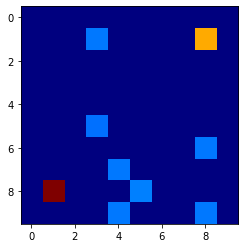

In [54]:
row_sums = conf.sum(axis=1, keepdims=True)
norm_conf_mx = conf / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.imshow(norm_conf_mx, cmap = "jet")
plt.show()

#### Perceptron

In [56]:
# Perceptron
conf = confusion_matrix(y_test, sgd_pred)
df = pd.DataFrame(data=conf, index=pd.RangeIndex(start=0,stop=10),
                  columns=np.arange(start=0, stop=10))
df

,0,1,2,3,4,5,6,7,8,9
0,35,0,0,0,0,0,1,0,0,0
1,0,29,0,1,0,0,3,0,3,0
2,0,0,35,0,0,0,0,0,0,0
3,0,0,0,37,0,0,0,0,0,0
4,0,0,0,0,35,0,1,0,0,0
5,0,0,0,0,0,36,1,0,0,0
6,0,0,0,0,0,0,35,0,1,0
7,0,0,0,0,0,0,0,36,0,0
8,0,2,0,0,0,0,1,1,31,0
9,0,0,0,0,0,0,0,3,1,32


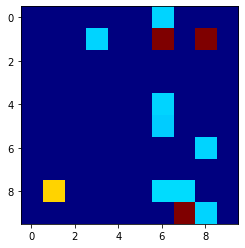

In [57]:
row_sums = conf.sum(axis=1, keepdims=True)
norm_conf_mx = conf / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.imshow(norm_conf_mx, cmap = "jet")
plt.show()

**Conclusions**<br>
The best algorithm for both binary and multiclass classification is logistic regression. The largest source of error of the logistic regression algorithm is the 8 predicted as 2 and vice versa. The Perceptron has more pathes where the alorithm makes mistakes.